# Gaussian Process Regression on Stock Prices


**The key idea stems from the prior knowledge that observations made right after another are similar than those made at distant intervals. This helps to design the n-dimensional(n->time stamp in this case) Gaussian distribution from which the posterior is obtained by conditioning on the observation(y). This conditioning provides a much concise variance and mean of the predicted values - We call them confidence intervals-crucial for forecasting equities.**

**My code deploys GPR on the dataset of Yahoo stocks over a limited range due to the constraint on resources.**

In [804]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# Loading the Yahoo_stock dataset

In [805]:
np.random.seed(1)
dataset = pd.read_csv('yahoo_stock.csv')
dataset.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


**Transforming dataset into array**


In [806]:
ds_arr = np.asarray(dataset)

date = ds_arr[0:50, 0]


In [807]:
High = ds_arr[0:70, 1]
Low = ds_arr[0:70, 2]
Open = ds_arr[0:70, 3]
Close = ds_arr[0:70, 4]
Volume = ds_arr[0:70, 5]
Adj_Close = ds_arr[0:70, 6]


**Concatenating all attributes into one array as y->observation**

In [808]:
y_train = np.asarray([High, Low, Open, Close, Volume, Adj_Close]).T
print(y_train.shape)


(70, 6)


**Defining X-input as instances of time**


In [809]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = np.atleast_2d(np.linspace(-250, 250, 70)).T
X_test = np.atleast_2d(np.linspace(-250,300, 500)).T
print(X_train.shape)
print(y_train.shape)


(70, 1)
(70, 6)


**Instantiating a Gaussian Process Model**

In [810]:
kernel = RBF(length_scale = 20, length_scale_bounds=(1e-1, 8))
gp = GaussianProcessRegressor(kernel = kernel, random_state=0)

kernel2 = ConstantKernel(constant_value=2)*RBF(length_scale=100, length_scale_bounds=(0.1, 100000.0))
gp2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer = 100, random_state=1)

**Building the Priors with RBF and ExpSq kernels**

Text(0.5, 1.0, '3 samples from GP Prior using Combined Kernel')

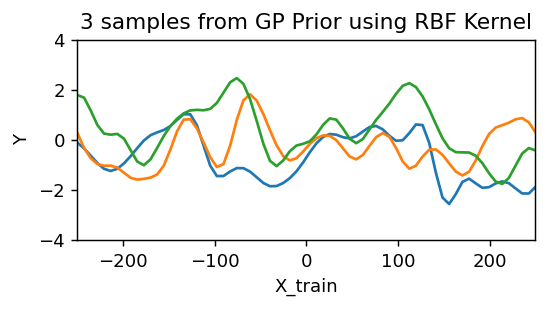

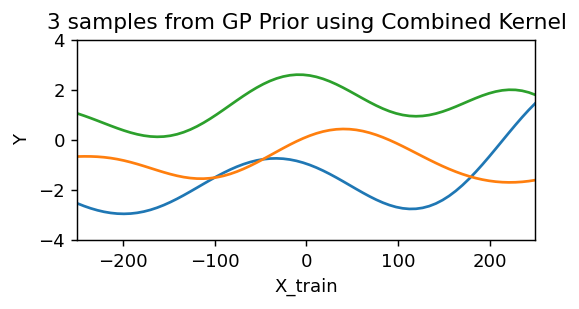

In [811]:
mu_prior = np.zeros(X_train.shape)
sigma_prior = kernel(X_train, X_train)

#samples_prior = np.random.multivariate_normal(mu_prior.reshape(-1), sigma_prior, 3).T
samples_prior = gp.sample_y(X_train, 3)

fig = plt.figure(figsize=(10,2), dpi=130, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(X_train, samples_prior, ms=1)
plt.xlabel('X_train')
plt.xlim(-250,250)
plt.ylim(-4,4)
plt.ylabel('Y')
plt.title('3 samples from GP Prior using RBF Kernel')


samples_prior2 = gp2.sample_y(X_train, 3)

fig = plt.figure(figsize=(10,2), dpi=130, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(X_train, samples_prior2)
plt.xlabel('X_train')
plt.xlim(-250,250)
plt.ylim(-4,4)
plt.ylabel('Y')
plt.title('3 samples from GP Prior using Combined Kernel')




**Fitting model to data**

(500, 6, 3)


(1950.0, 2200.0)

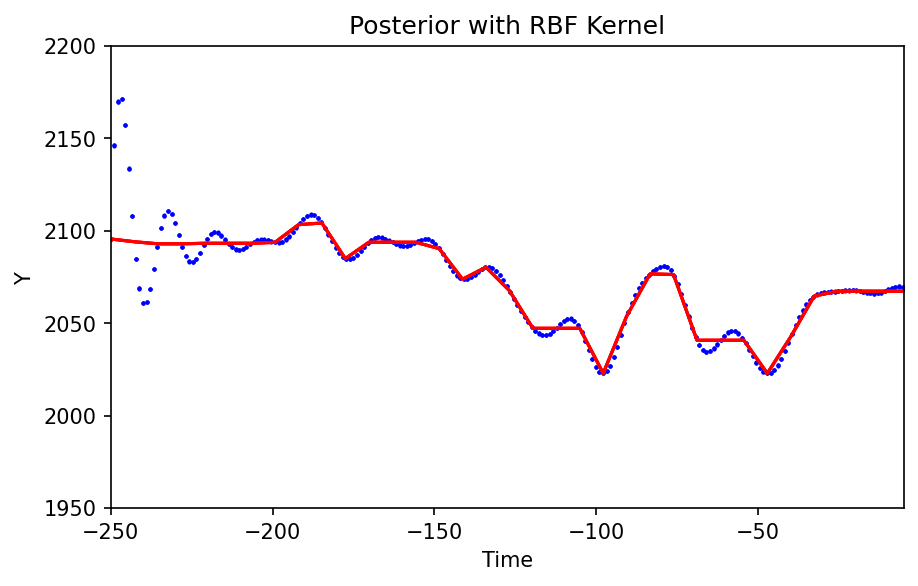

In [812]:
gp.fit(X_train,y_train)

sample_post1 = gp.sample_y(X_test, n_samples=3, random_state=8)
sample_post2 = gp.sample_y(X_train, n_samples=3, random_state=3)
#sample_post3 = gp2.sample_y(X_test, n_samples=3, random_state=5)



print(sample_post1.shape)


fig = plt.figure(figsize=(15,4), dpi=150, facecolor='w')

plt.subplot(1,2,1)
plt.plot(X_test, sample_post1[:,0], 'o', color='blue', markersize=1, label=u'Sample 1')
plt.plot(X_train, sample_post2[:,0],  '-', color='red', markersize=1, label=u'Sample 2')
#plt.plot(X_test, sample_post3[:,0],  color='green', markersize=3, label=u'Sample 2')


#plt.plot(X_test, y_pred1[:,0], 'b-', linewidth=1, label=u'Prediction')

#plt.fill_between(X_test[:,0], y_pred1[:,0]-1.96*sigma_rbf, y_pred1[:,0]+1.96*sigma_rbf, alpha = 0.2, color='k', label=u'95% confidence interval')
plt.title('Posterior with RBF Kernel')
plt.xlabel('Time')
plt.ylabel('Y')
plt.xlim(-250,-5)
plt.ylim(1950,2200)



In [813]:

gp2.fit(X_train, y_train)

C:\Users\Ritwik\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1.41**2 * RBF(length_scale=100),
                         n_restarts_optimizer=100, random_state=1)

**Predicting on Test data with Confidence Interval**

(1700.0, 2300.0)

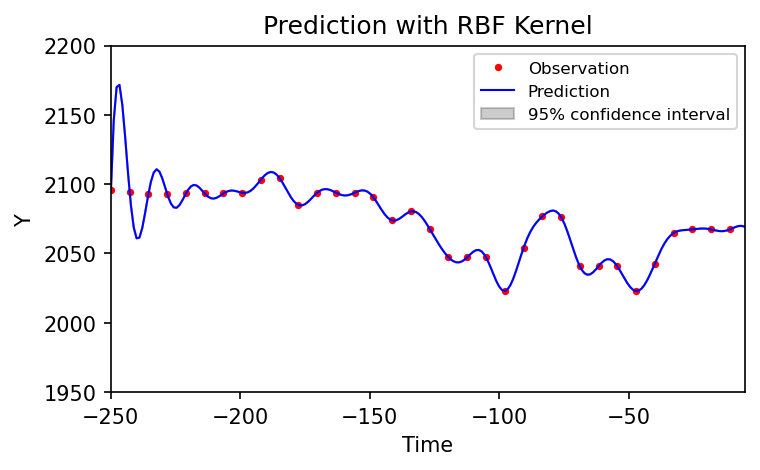

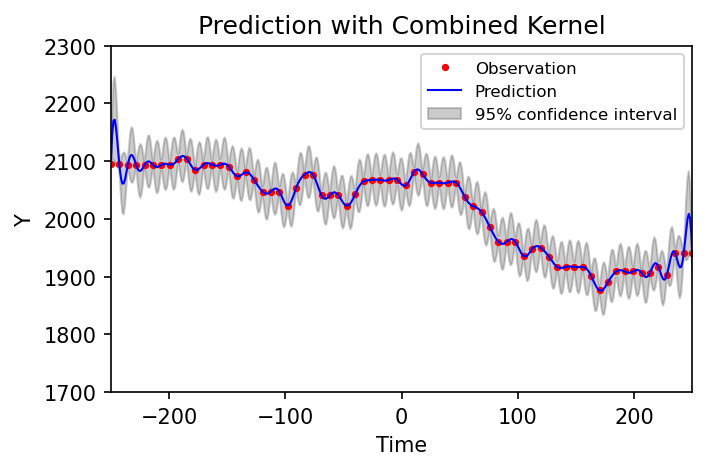

In [814]:

#samples_posterior = gp.sample_y(X_test, 3)

y_pred1, sigma_rbf = gp.predict(X_test, return_std=True)
y_pred2, sigma_comb = gp2.predict(X_test, return_std=True)

fig = plt.figure(figsize=(12,3), dpi=150, facecolor='w', edgecolor='aliceblue')

plt.subplot(1,2,1)
plt.plot(X_train, y_train[:,0], 'r.', markersize=5, label=u'Observation')
plt.plot(X_test, y_pred1[:,0], 'b-', linewidth=1, label=u'Prediction')

plt.fill_between(X_test[:,0], y_pred1[:,0]-1.96*sigma_rbf, y_pred1[:,0]+1.96*sigma_rbf, alpha = 0.2, color='k', label=u'95% confidence interval')
plt.title('Prediction with RBF Kernel')
plt.xlabel('Time')
plt.ylabel('Y')

plt.legend(loc='upper right', fontsize=8)
plt.xlim(-250,-5)
plt.ylim(1950,2200)


fig2 = plt.figure(figsize=(11,3), dpi=150, facecolor='w', edgecolor='aliceblue')

plt.subplot(1,2,1)
plt.plot(X_train, y_train[:,0], 'r.', markersize=5, label=u'Observation')
plt.plot(X_test, y_pred2[:,0], 'b-', linewidth=1, label=u'Prediction')

plt.fill_between(X_test[:,0], y_pred2[:,0]-1.96*sigma_comb, y_pred2[:,0]+1.96*sigma_comb, alpha = 0.2, color='k', label=u'95% confidence interval')
plt.title('Prediction with Combined Kernel')
plt.xlabel('Time')
plt.ylabel('Y')

plt.legend(loc='upper right', fontsize=8)
plt.xlim(-250,250)
plt.ylim(1700,2300)
